<a href="https://colab.research.google.com/github/LeeYoungJun1113/3D_CT_SEG/blob/main/K_2023_0208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/seg/DICOM

! unzip -qq "/content/drive/MyDrive/seg/DICOM/Liver.zip"


/content/drive/MyDrive/seg/DICOM


In [1]:
!pip install pydicom
!pip install dicom
!pip install opencv-python
!pip install natsort
!pip install simpleitk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2, pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut 
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from natsort import natsorted

import tensorflow as tf

import sys
import random
import warnings
warnings.filterwarnings('ignore')

import cv2 
import os
from PIL import Image
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import nibabel as nib
import SimpleITK as sitk



from pylab import rcParams

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import  Conv2D,  MaxPooling2D, GlobalMaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

/usr/local/lib/python3.8/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [ ]:
# sitk.ReadImage('/content/drive/MyDrive/K/infer_pre/mask_3/IMG0001.dcm').GetDirection()

In [ ]:
# print(pydicom.read_file('/content/drive/MyDrive/K/infer_pre/input/1-001.dcm'))

In [ ]:
# CT & Mask image path
ct_path = natsorted(glob('/content/drive/MyDrive/K/infer_pre/input_1/*.dcm'))
mask_path = natsorted(glob('/content/drive/MyDrive/K/infer_pre/mask_1/*.dcm'))

# graph function
def show_image(path):
    slice = pydicom.read_file(path)
    s = int(slice.RescaleSlope)
    b = int(slice.RescaleIntercept)
    image = s * slice.pixel_array + b

    plt.figure(figsize=(16, 16), dpi=60) 
    plt.subplot(1,3,1)
    plt.title('DICOM -> Array')
    plt.imshow(image, cmap = 'gray')

    # apply_modality_lut( ) & apply_voi_lut( )
    window_center = -600
    window_width = 1600
    slice.WindowCenter = window_center
    slice.WindowWidth = window_width
    image = apply_modality_lut(image, slice)
    image2 = apply_voi_lut(image, slice)
    plt.subplot(1,3,2)
    plt.title('apply_voi_lut( )')
    plt.imshow(image2, cmap = 'gray')  

    # normalization
    image3 = np.clip(image, window_center - (window_width / 2), window_center + (window_width / 2))

    # plt.show()​
    plt.subplot(1,3,3)
    plt.title('normalize')
    plt.imshow(image3, cmap = 'gray')

# index = 70
# show_image(ct_path[index])
# show_image(mask_path[115-index])

rando = np.random.randint(0, len(ct_path), size=3)
for i in rando:
  show_image(ct_path[i])
  show_image(mask_path[115-i])

# for index in [70,71]:
#     show_image(ct_path[index])
#     show_image(mask_path[115-index])

# for i in zip(glob.glob(ct_path), glob.glob(mask_path)):
#   show image()
# # for ct, mask in zip(glob.glob(ct_path), glob.glob(mask_path)):
#     show_image(ct)
#     show_image(mask)

In [ ]:
# Load Image Data [Lung]
# Convert to np array

cts = []
masks = []
img_size = 512
ct_path_dir = '/content/drive/MyDrive/seg/DICOM/Original'
mask_path_dir = '/content/drive/MyDrive/seg/DICOM/Lung'
for i in range(1,8):
    file_ct_path = natsorted(glob(os.path.join(ct_path_dir, str(i), '*.dcm')))
    for j in range(len(file_ct_path)):
      slice = pydicom.read_file(file_ct_path[j])
      s = int(slice.RescaleSlope)
      b = int(slice.RescaleIntercept)
      image = s * slice.pixel_array + b
      
      cts.append(image)
      
for i in range(1,8):
    file_mask_path = natsorted(glob(os.path.join(mask_path_dir, str(i), '*.dcm')))
    for j in range(len(file_mask_path)):
      m_slice = pydicom.read_file(file_mask_path[j])
      ss = int(m_slice.RescaleSlope)
      bb = int(m_slice.RescaleIntercept)
      m_image = ss * m_slice.pixel_array + bb
      
      masks.append(m_image)

In [3]:
# Load Image Data [Liver]
# Convert to np array

livs = []
lmasks = []
img_size = 512
livs_path_dir = '/content/drive/MyDrive/seg/DICOM_2/Orig_2'
lmask_path_dir = '/content/drive/MyDrive/seg/DICOM_2/Liver_2'
for i in range(1,7):
    file_livs_path = natsorted(glob(os.path.join(livs_path_dir, str(i), '*.dcm')))
    for j in range(len(file_livs_path)):
      slice = pydicom.read_file(file_livs_path[j])
      s = int(slice.RescaleSlope)
      b = int(slice.RescaleIntercept)
      image = s * slice.pixel_array + b
      
      livs.append(image)
      
for i in range(1,7):
    file_lmask_path = natsorted(glob(os.path.join(lmask_path_dir, str(i), '*.dcm')))
    for j in range(len(file_lmask_path)):
      m_slice = pydicom.read_file(file_lmask_path[j])
      ss = int(m_slice.RescaleSlope)
      bb = int(m_slice.RescaleIntercept)
      m_image = ss * m_slice.pixel_array + bb
      
      lmasks.append(m_image)

In [ ]:
cts = np.array(cts)
cts = cts.reshape(len(cts), img_size, img_size, 1)

masks = np.array(masks)
#masks = masks[::-1]
masks = masks.reshape(len(masks), img_size, img_size, 1)

In [4]:
livs = np.array(livs)
livs = livs.reshape(len(livs), img_size, img_size, 1)
livs = livs/255.

lmasks = np.array(lmasks)
#masks = masks[::-1]
lmasks = lmasks.reshape(len(lmasks), img_size, img_size, 1)
lmasks = lmasks/255.

In [56]:
print(livs.dtype, lmasks.dtype)

float64 float64


In [ ]:
print(cts.shape, masks.shape)

In [57]:
print(livs.shape, lmasks.shape)

(583, 512, 512, 1) (583, 512, 512, 1)


In [ ]:
plt.figure
plt.imshow(masks[20].reshape(512,512), cmap='bone')

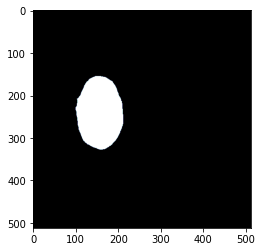

In [29]:
plt.figure
plt.imshow(lmasks[72].reshape(512,512), cmap='bone')

In [ ]:
def plot_sample(array_list, color_map = 'gray'):

  fig = plt.figure(figsize = (10,30))

  plt.subplot(1,2,1)
  plt.imshow(array_list[0].reshape(512,512), cmap='bone')
  plt.title('Train CT data')

  plt.subplot(1,2,2)
  plt.imshow(array_list[0].reshape(512,512), cmap='bone')
  plt.imshow(array_list[1].reshape(512,512), alpha=0.5, cmap='jet')
  plt.title('Train Mask')
  plt.show()

rando = np.random.randint(0, len(cts), size=5)
for i in rando:
  plot_sample([cts[i], masks[i]])

#  for i in [50,60,70,80]:
#   plot_sample([cts[i], masks[i]])

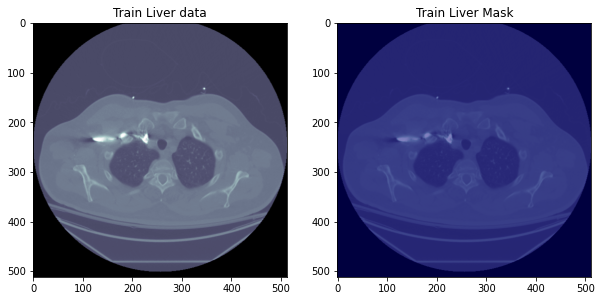

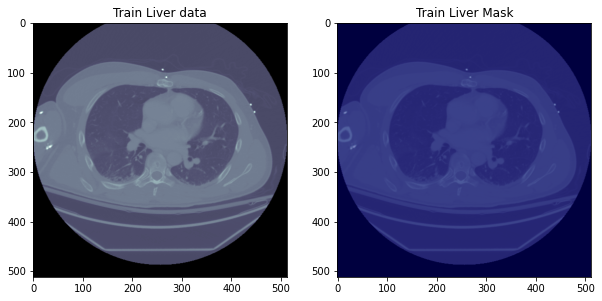

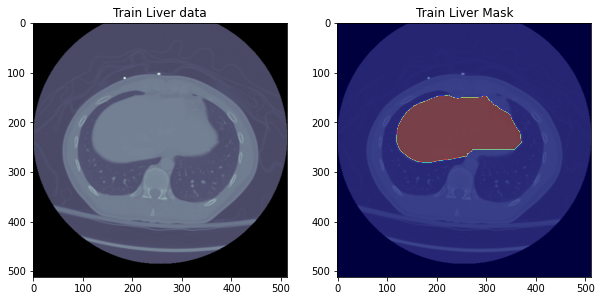

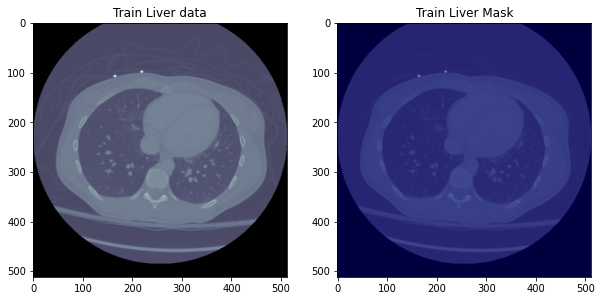

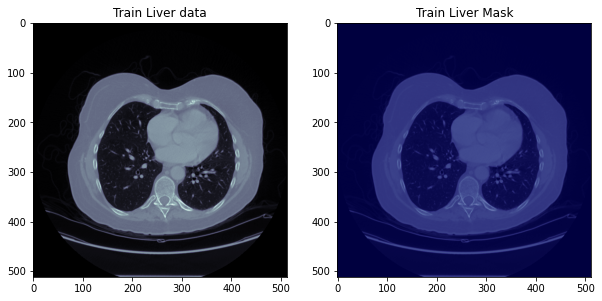

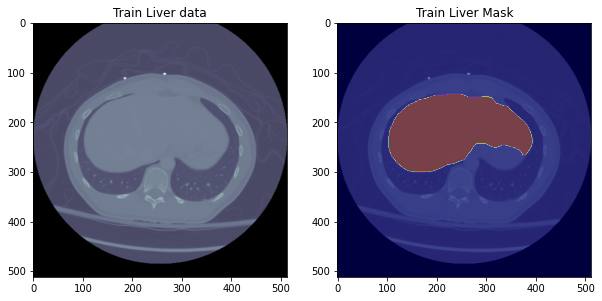

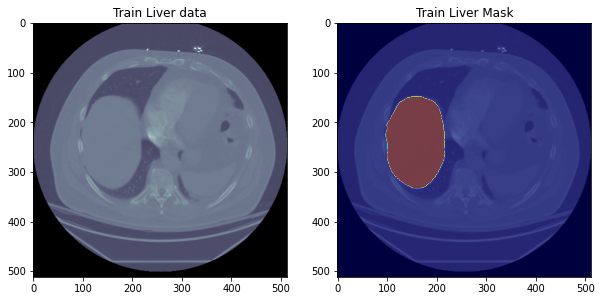

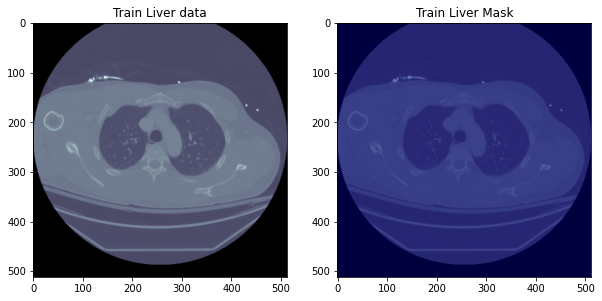

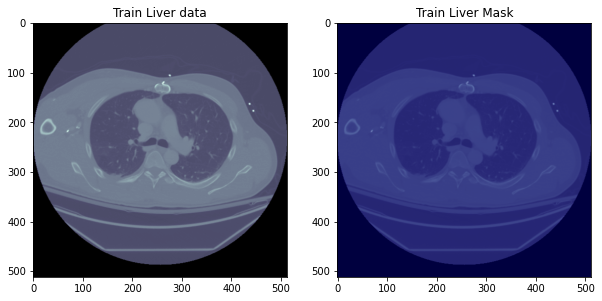

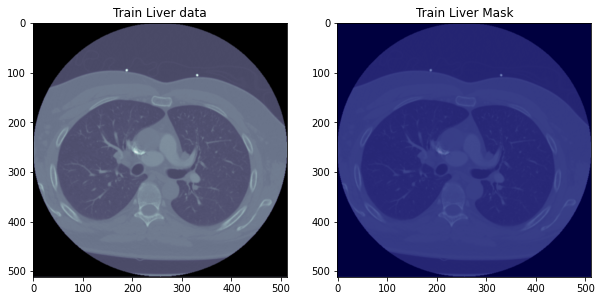

In [5]:
def plot_sample(array_list, color_map = 'gray'):

  fig = plt.figure(figsize = (10,30))

  plt.subplot(1,2,1)
  plt.imshow(array_list[0].reshape(512,512), cmap='bone')
  plt.title('Train Liver data')

  plt.subplot(1,2,2)
  plt.imshow(array_list[0].reshape(512,512), cmap='bone')
  plt.imshow(array_list[1].reshape(512,512), alpha=0.5, cmap='jet')
  plt.title('Train Liver Mask')
  plt.show()

rando = np.random.randint(0, len(livs), size=10)
for i in rando:
  plot_sample([livs[i], lmasks[i]])

In [ ]:
# # Load Image Data
# # Convert to np array

# cts = []
# masks = []
# img_size = 512

# cts = sitk.GetArrayFromImage(sitk.ReadImage(ct_path))
# cts = np.array(cts).astype('uint8')
# cts = cts.reshape(len(cts), img_size, img_size, 1) 

# masks = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
# masks = np.array(masks).astype('uint8')
# masks = cts.reshape(len(masks), img_size, img_size, 1) 


In [ ]:
# # Load target label

# y_label = []

# for i in range(0, len(masks)):
#   if len(np.unique(masks[i]))!=1:
#     y_label.append(1)
#   else:
#     y_label.append(0)
# print(y_label.count(0), y_label.count(1))

# y_label = np.array(y_label)

In [5]:
# Building unet model

def u_model(input_layer, start_neurons, DropoutRatio = 0.25):

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation='relu', padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = BatchNormalization()(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = BatchNormalization()(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = BatchNormalization()(uconv2)
        
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = BatchNormalization()(uconv1)
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    
    output_layer = Conv2D(1, (1,1), activation="sigmoid")(uconv1)
    
    return output_layer

In [ ]:
# Another model

from tensorflow.keras.applications.resnet import ResNet50
#input = Input(shape=(img_size, img_size, 3))
model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(512,512,3))

In [6]:
# Define Metrics
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.5*K.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

# def dice_loss(y_true, y_pred):
#   y_true = tf.cast(y_true, tf.float32)
#   y_pred = tf.math.sigmoid(y_pred)
#   numerator = 2 * tf.reduce_sum(y_true * y_pred)
#   denominator = tf.reduce_sum(y_true + y_pred)

#   return 1 - numerator / denominator

In [ ]:
# Training Model_Lung

print(cts.shape, masks.shape)
# cts = cts/255.
# masks = masks/255.

x_train, x_valid, y_train, y_valid = train_test_split(cts, masks, test_size=0.2, random_state=42)
print(x_train.shape, x_valid.shape)

epochs = 50
batch_size = 32

# initialize this model
inputs = Input((img_size, img_size, 1))
output_layer = u_model(inputs, 32, 0.25)

# Define callbacks to save model with best val_dice_coef
filename = '/content/drive/MyDrive/seg/model_0114.h5'
checkpointer = ModelCheckpoint(filepath = filename, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
#earlystopping = EarlyStopping(monitor='val_loss', patience=5)
model = Model(inputs=[inputs], outputs=[output_layer])
model.compile(optimizer=Adam(lr = 1e-5), loss='bce_dice_loss', metrics=[dice_coef])

results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid),callbacks=[checkpointer])
# model.save('my_model')

In [ ]:
# Training Model_liver

print(livs.shape, lmasks.shape)
print(livs.dtype, lmasks.dtype)
# livs = livs/255.
# lmasks = lmasks/255.

x_train, x_valid, y_train, y_valid = train_test_split(livs, lmasks, test_size=0.2, random_state=42)
print(x_train.shape, x_valid.shape)

epochs = 50
batch_size = 16

# initialize this model
inputs = Input((img_size, img_size, 1))
output_layer = u_model(inputs, 32, 0.25)

# Define callbacks to save model with best val_dice_coef
filename = '/content/drive/MyDrive/seg/livers_model_32_0208.h5'
checkpointer = ModelCheckpoint(filepath = filename, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
#earlystopping = EarlyStopping(monitor='val_loss', patience=5)
model = Model(inputs=[inputs], outputs=[output_layer])
model.compile(optimizer=Adam(lr = 1e-5), loss= dice_loss, metrics=[dice_coef])

results = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid),callbacks=[checkpointer])
# model.save('my_model')

(583, 512, 512, 1) (583, 512, 512, 1)
float64 float64
(466, 512, 512, 1) (117, 512, 512, 1)


In [ ]:
model.save('/content/drive/MyDrive/seg/model_0101.h5')

In [44]:
# Evaluate the trained model 
score = model.evaluate(x_valid, y_valid, batch_size=batch_size)
print("test loss, test dice coefficient:", score)

15/15 [==============================] - 4s 234ms/step - loss: 0.5014 - dice_coef: 0.0030
test loss, test dice coefficient: [0.5013560652732849, 0.0029702442698180676]


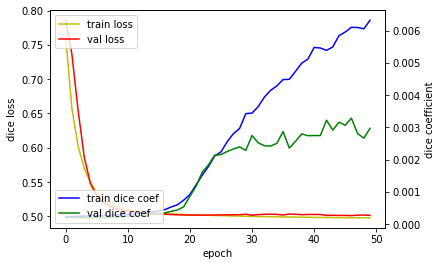

In [45]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('dice loss')
acc_ax.set_ylabel('dice coefficient')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [46]:
# Visualize the results

def compare_actual_and_predicted(image_no):
  temp = model.predict(x_valid[image_no].reshape(1, img_size, img_size, 1))

  fig = plt.figure(figsize=(15,15))

  plt.subplot(1,3,1)
  plt.imshow(x_valid[image_no].reshape(img_size, img_size), cmap='bone')
  plt.axis('off')
  plt.title('Original Image (CT)')

  plt.subplot(1,3,2)
  plt.imshow(y_valid[image_no].reshape(img_size, img_size), cmap='bone')
  plt.axis('off')
  plt.title('True mask')

  plt.subplot(1,3,3)
  plt.imshow(temp.reshape(img_size, img_size), cmap='bone')
  plt.axis('off')
  plt.title('Predicted mask')

  plt.show()

1/1 [==============================] - 2s 2s/step


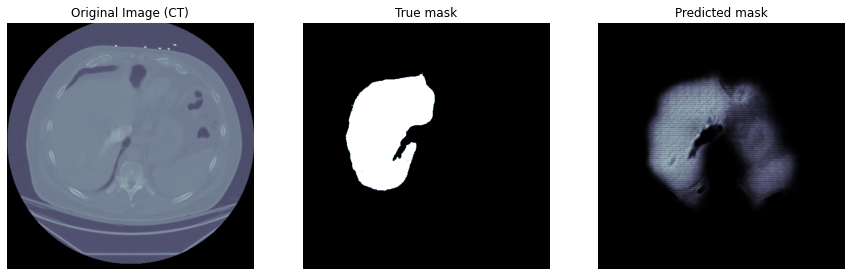

1/1 [==============================] - 0s 22ms/step


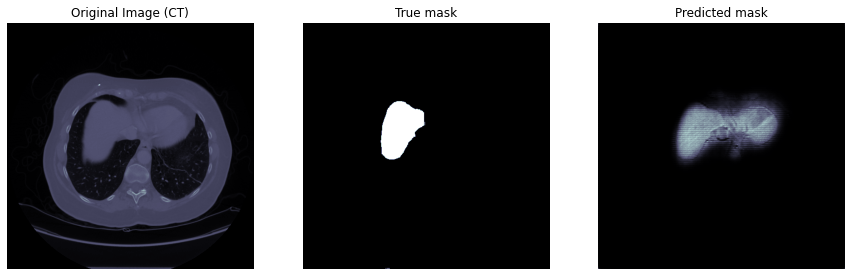

1/1 [==============================] - 0s 25ms/step


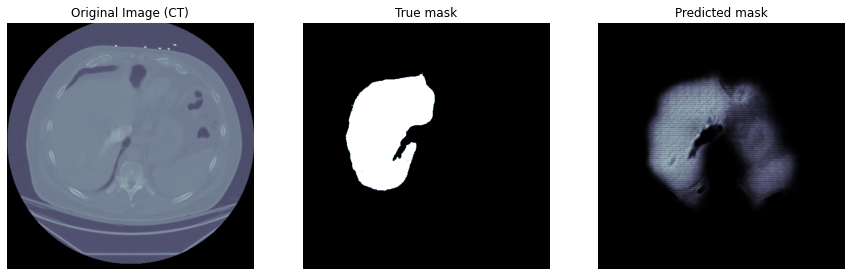

1/1 [==============================] - 0s 20ms/step


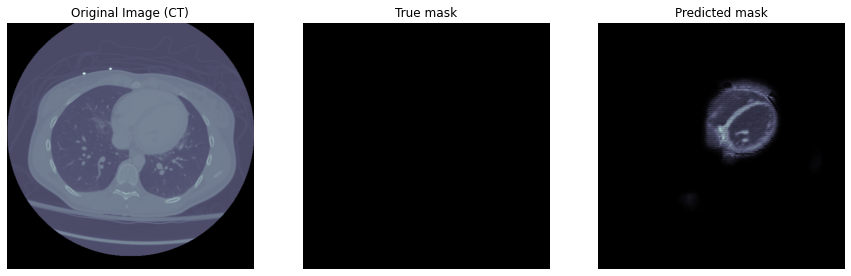

1/1 [==============================] - 0s 21ms/step


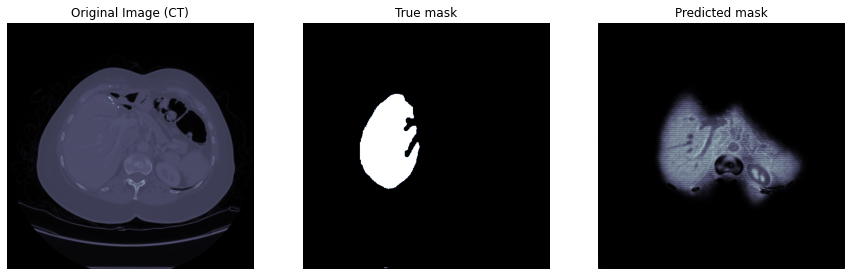

1/1 [==============================] - 0s 21ms/step


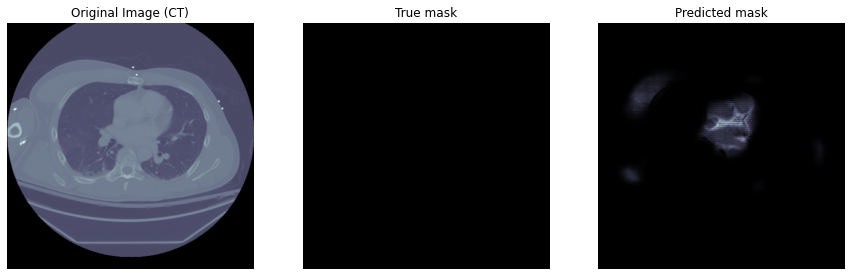

1/1 [==============================] - 0s 28ms/step


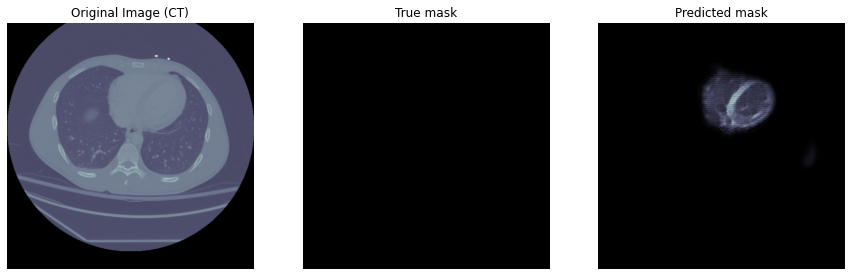

1/1 [==============================] - 0s 21ms/step


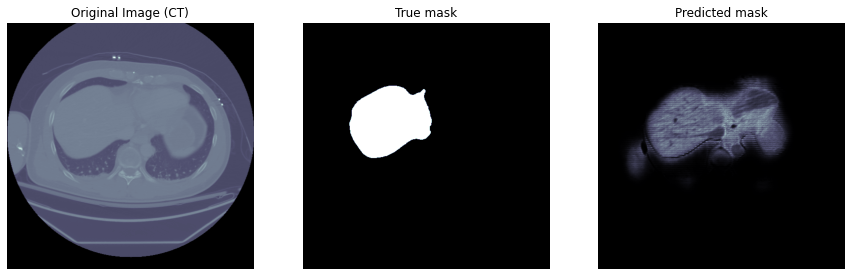

1/1 [==============================] - 0s 23ms/step


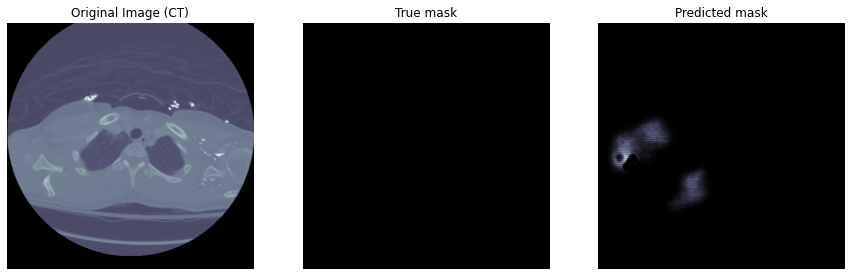

1/1 [==============================] - 0s 21ms/step


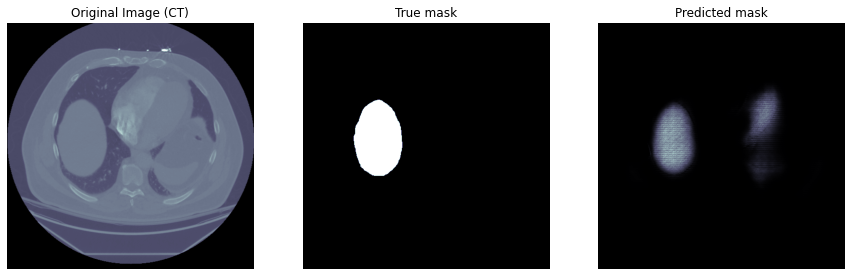

In [47]:
rand = np.random.randint(0, len(x_valid), size=10)
for i in rand:
  compare_actual_and_predicted(i)

In [ ]:
# Check the new model's architecture

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
dependencies = {'dice_coef': dice_coef}

In [ ]:
# Continue to train with the latest model

filepath = '/content/drive/MyDrive/seg/model_0101_2.h5'
new_model = load_model(filepath, custom_objects=dependencies)


model = new_model

x_train, x_valid, y_train, y_valid = train_test_split(livs, lmasks, test_size=0.2, random_state=42)
print(x_train.shape, x_valid.shape)

epochs = 100
batch_size = 16

# # initialize this model
# inputs = Input((img_size, img_size, 1))
# output_layer = u_model(inputs, 32, 0.25)

filename = '/content/drive/MyDrive/seg/model_0101_3.h5'
checkpointer = ModelCheckpoint(filepath = filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.compile(optimizer=Adam(lr = 1e-5), loss='binary_crossentropy', metrics=[dice_coef])
results2 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid),callbacks=[checkpointer])
score = model.evaluate(x_valid, y_valid, batch_size=batch_size)

print("test loss, test dice coefficient:", score)

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results2.history['loss'], 'y', label='train loss')
loss_ax.plot(results2.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results2.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results2.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('dice loss')
acc_ax.set_ylabel('dice coefficient')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
# Visualize the results

def compare_actual_and_predicted(image_no):
  temp = model.predict(x_valid[image_no].reshape(1, img_size, img_size, 1))

  fig = plt.figure(figsize=(15,15))

  plt.subplot(1,3,1)
  plt.imshow(x_valid[image_no].reshape(img_size, img_size), cmap='bone')
  plt.axis('off')
  plt.title('Original Image (CT)')

  plt.subplot(1,3,2)
  plt.imshow(y_valid[image_no].reshape(img_size, img_size), cmap='bone')
  plt.axis('off')
  plt.title('True mask')

  plt.subplot(1,3,3)
  plt.imshow(temp.reshape(img_size, img_size), cmap='bone')
  plt.axis('off')
  plt.title('Predicted mask')

  plt.show()

In [ ]:
rand = np.random.randint(0, len(x_valid), size=10)
for i in rand:
  compare_actual_and_predicted(i)

## **MODEL INFERENCE**

In [ ]:
dependencies = {'dice_coef': dice_coef}

filepath = '/content/drive/MyDrive/seg/model_0101_3.h5'
new_model = load_model(filepath, custom_objects=dependencies)

In [ ]:
#### Model Inference

# Prepare testset 
x_test = []
tmasks = []
img_size = 512
test_path_dir = '/content/drive/MyDrive/seg/DICOM/input'
tmask_path_dir = '/content/drive/MyDrive/seg/DICOM/Lung_2'
for i in range(1):
    file_test_path = natsorted(glob(os.path.join(test_path_dir, '*.dcm')))
    for j in range(len(file_test_path)):
      slice = pydicom.read_file(file_test_path[j])
      s = int(slice.RescaleSlope)
      b = int(slice.RescaleIntercept)
      image = s * slice.pixel_array + b
      
      x_test.append(image)

for i in range(1):
    file_tmask_path = natsorted(glob(os.path.join(tmask_path_dir, '*.dcm')))
    for j in range(len(file_tmask_path)):
      m_slice = pydicom.read_file(file_tmask_path[j])
      ss = int(m_slice.RescaleSlope)
      bb = int(m_slice.RescaleIntercept)
      m_image = ss * m_slice.pixel_array + bb
      
      tmasks.append(m_image)      

In [ ]:
file_tmask_path

In [ ]:
x_test = np.array(x_test)
x_test = x_test.reshape(len(x_test), img_size, img_size, 1)

tmasks = np.array(tmasks)
tmasks = tmasks[::-1]
tmasks = tmasks.reshape(len(tmasks), img_size, img_size, 1)

In [ ]:
def plot_sample_test(array_list, color_map = 'gray'):

  fig = plt.figure(figsize = (10,30))

  plt.subplot(1,2,1)
  plt.imshow(array_list[0].reshape(512,512), cmap='bone')
  plt.title('Test CT')

  plt.subplot(1,2,2)
  plt.imshow(array_list[0].reshape(512,512), cmap='bone')
  plt.imshow(array_list[1].reshape(512,512), alpha=0.5, cmap='jet')
  plt.title('Test Mask')
  plt.show()

rando = np.random.randint(0, len(x_test), size=5)
for i in rando:
  plot_sample_test([x_test[i], tmasks[i]])

In [ ]:
# Visualize the results

def compare_actual_and_predicted_test(image_no):
  temp = new_model.predict(x_test[image_no].reshape(1, img_size, img_size, 1))

  fig = plt.figure(figsize=(15,15))

  plt.subplot(1,3,1)
  plt.imshow(x_test[image_no].reshape(img_size, img_size), cmap='bone')
  plt.axis('off')
  plt.title('Test Image (CT)')

  plt.subplot(1,3,2)
  plt.imshow(tmasks[image_no].reshape(img_size, img_size), cmap='bone')
  plt.axis('off')
  plt.title('Test masks (CT)')

  plt.subplot(1,3,3)
  plt.imshow(temp.reshape(img_size, img_size), cmap='bone')
  plt.axis('off')
  plt.title('Test Prediction')

  plt.show()

In [ ]:
rand = np.random.randint(0, len(x_test), size=10)
for i in rand:
  compare_actual_and_predicted_test(i)

# Evaluation of Classification Performance

In [ ]:
x_valid = x_valid[:].astype(int)

In [ ]:
temp = model.predict(x_valid[:])

1/1 [==============================] - 0s 376ms/step


In [ ]:
print(temp)

In [ ]:
print(x_valid)

In [ ]:
temp_label = temp.argmax(axis=1)

In [ ]:
temp_label

In [ ]:
temp = np.where(temp>0.5, 1, 0)

In [ ]:
# x_valid = x_valid.argmax(axis=1)
x_valid = np.where(x_valid>0.5, 1, 0)

In [ ]:
print(temp.shape, x_valid.shape)

(21, 512, 512, 1) (21, 512, 512, 1)


In [ ]:
x_valid.dtype

In [ ]:
temp_label

In [ ]:
print(temp.dtype, x_valid.dtype)

int64 int64


CONFUSION MATRIX

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(x_valid, temp))

ValueError: ignored

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(x_valid, temp_label)